# Imports

In [1]:
! pip install swifter &> /dev/null
! pip install spacy &> /dev/null
! pip install textacy &> /dev/null

In [114]:
import spacy
import pandas as pd
from tqdm.auto import tqdm 
import swifter
import numpy as np
import plotly.express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import os
import re
import gensim
import string
import textacy
from collections import Counter
from nltk.util import ngrams
from matplotlib import pyplot
import seaborn as sns
pd.options.plotting.backend = "plotly"
import csv
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure

In [3]:
! python -m spacy download en_core_web_md &> /dev/null
! pip install spacytextblob &> /dev/null

In [4]:
from spacytextblob.spacytextblob import SpacyTextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
en = spacy.load("en_core_web_md")
en.add_pipe('spacytextblob')

# Data import

In [55]:
path = "drive/MyDrive/Commission Adoption Feedback/feedback-text.csv"
file = open(path, "r")
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
rows = []
for row in csvreader:
    rows.append(row)
print(rows)
file.close()

['\ufeffF2256808', 'F2665651', 'F2665650', 'F2665649', 'F2665648', 'F2665647', 'F2665646', 'F2665645', 'F2665643', 'F2665642', 'F2665641', 'F2665640', 'F2665639', 'F2665638', 'F2665637', 'F2665634', 'F2665633', 'F2665632', 'F2665629', 'F2665628', 'F2665627', 'F2665626', 'F2665625', 'F2665624', 'F2665623', 'F2665618', 'F2665617', 'F2665616', 'F2665615', 'F2665614', 'F2665611', 'F2665610', 'F2665609', 'F2665607', 'F2665605', 'F2665604', 'F2665603', 'F2665602', 'F2665600', 'F2665599', 'F2665595', 'F2665594', 'F2665591', 'F2665590', 'F2665589', 'F2665587', 'F2665586', 'F2665583', 'F2665582', 'F2665580', 'F2665579', 'F2665578', 'F2665576', 'F2665574', 'F2665573', 'F2665568', 'F2665565', 'F2665564', 'F2665563', 'F2665562', 'F2665561', 'F2665559', 'F2665558', 'F2665556', 'F2665554', 'F2665553', 'F2665551', 'F2665550', 'F2665548', 'F2665547', 'F2665546', 'F2665543', 'F2665542', 'F2665541', 'F2665540', 'F2665539', 'F2665537', 'F2665536', 'F2665535', 'F2665534', 'F2665533', 'F2665532', 'F2665530

In [56]:
df = pd.read_csv(path)
df=df.T
df.columns = ["No_attachment","With_attachment"]
df["No_attachment"] = df["No_attachment"].replace(np.nan, 'ATTACH')
df['word_count_no'] = df["No_attachment"].apply(lambda x : len(x.split()))
df['char_count_no'] = df['No_attachment'].apply(lambda x : len(x.replace(" ","")))
df['word_density_no'] = df['word_count_no'] / (df['char_count_no'] + 1)
df['word_count_w'] = df["With_attachment"].apply(lambda x : len(x.split()))
df['char_count_w'] = df['With_attachment'].apply(lambda x : len(x.replace(" ","")))
df['word_density_w'] = df['word_count_w'] / (df['char_count_w'] + 1)
df

,No_attachment,With_attachment,word_count_no,char_count_no,word_density_no,word_count_w,char_count_w,word_density_w
F2256808,ATTACH,Please find below our feedback on the AI impac...,1,6,0.142857,315,1568,0.200765
F2665651,ATTACH,Equinet welcomes the opportunity to provide co...,1,6,0.142857,144,859,0.167442
F2665650,ATTACH,AI Austria welcomes the opportunity to comment...,1,6,0.142857,77,392,0.195929
F2665649,ATTACH,This submission to the AIA consultation is sen...,1,6,0.142857,343,2090,0.164036
F2665648,ATTACH,The EU AI Act is an important step in the righ...,1,6,0.142857,463,2746,0.168548
...,...,...,...,...,...,...,...,...
F2488672,ATTACH,"Considering the space limits, we attach our co...",1,6,0.142857,26,169,0.152941
F2334478,Although among the purposes of the regulation ...,NO ATTACH,219,1213,0.180395,2,8,0.222222
F2324448,The proposed regulation is an excellent initia...,NO ATTACH,545,2956,0.184308,2,8,0.222222
F2256808.1,Please find below our feedback on the AI impac...,NO ATTACH,315,1568,0.200765,2,8,0.222222


In [57]:
df_no = df[df["With_attachment"] == "NO ATTACH"][['No_attachment','word_count_no','char_count_no','word_density_no']]
df_no.columns = ['Text','word_count','char_count','word_density']
df_no[:5]

,Text,word_count,char_count,word_density
F2665639,The Institute for Social Science Research e.V....,595,3361,0.176978
F2665628,"EFPA, The European Federation of Psychologists...",583,3404,0.171219
F2665605,EHFCN AI Working Group welcomes the proposal o...,270,1486,0.181574
F2665595,INFOBALT welcomes the European Commission’s Co...,532,3149,0.168889
F2665583,"Overall, Infineon Technologies AG welcomes the...",635,3266,0.194368


In [127]:
len(df_no)

37

In [58]:
df_w = df[df["No_attachment"] == "ATTACH"][['With_attachment','word_count_w','char_count_w','word_density_w']]
df_w.columns = ['Text','word_count','char_count','word_density']
df_w[:5]

,Text,word_count,char_count,word_density
F2256808,Please find below our feedback on the AI impac...,315,1568,0.200765
F2665651,Equinet welcomes the opportunity to provide co...,144,859,0.167442
F2665650,AI Austria welcomes the opportunity to comment...,77,392,0.195929
F2665649,This submission to the AIA consultation is sen...,343,2090,0.164036
F2665648,The EU AI Act is an important step in the righ...,463,2746,0.168548


# Data Cleaning

In [59]:
def my_lower(text):
    return text.lower()

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def custom_regex(text):
    ref=re.compile(r'ref|\.')
    ares=re.compile(r'ares|\(20(?:00|1[09]|2[01])\)')
    com=re.compile(r'com\([0-9]{1,4}\)')
    bignum = re.compile(r'[0-9]{5,30}')
    parenth = re.compile(r'\([0-9]{1,4}\)')
    email = re.compile(r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)')
    listing = re.compile(r'\([1-3]\)|\[[1-3]\]|[1-3]\.')
    page1 = re.compile(r'Page [0-9]{1,2}(?: \/ |\/)[0-9]{1,2}}')
    page2 = re.compile(r'Page [0-9]{1,2} of [0-9]{1,2}')
    page3 = re.compile(r'[0-9]{1,2} of [0-9]{1,2}')
    marks = re.compile(r'[\u2612\uF0B7\\x2D\u2022\u2713]')
    roman = re.compile(r'x(?:v?iii|i[vx]|x)|x(?:v?ii|vi?|i)?|v(?:i(?:ii|\.)|\.)|i(?:ii?\.|v\.|[\.x])|vii')
    questionaire = re.compile(r'1\-Not important at all|5\- Very important|2\- Not important|No opinion|4Important|3Neutral')
    text = ref.sub(r'',text)
    text = ares.sub(r'',text)
    text = com.sub(r'',text)
    text = bignum.sub(r'',text)
    text = parenth.sub(r'',text)
    text = email.sub(r'',text)
    text = listing.sub(r'',text)
    text = page1.sub(r'',text)
    text = page2.sub(r'',text)
    text = page3.sub(r'',text)
    text = marks.sub(r'',text)
    text = roman.sub(r'',text)
    text = questionaire.sub(r'',text)
    return text

def clean(df,text_col='Text'):
  df[text_col]=df[text_col].apply(lambda x : my_lower(x))
  df[text_col]=df[text_col].apply(lambda x : remove_URL(x))
  df[text_col]=df[text_col].apply(lambda x : remove_html(x))
  df[text_col]=df[text_col].apply(lambda x : remove_punct(x))
  df[text_col]=df[text_col].apply(lambda x : custom_regex(x))
  return df

In [91]:
df_no = clean(df_no)
df_w = clean(df_w)

df = [df_no,df_w]
df = pd.concat(df)

# Tokenization

To poniżej trwa stasznie długo

In [73]:
tqdm.pandas()
docs_no = df_no['Text'].swifter.apply(en)
docs_w = df_w['Text'].swifter.apply(en)
docs = [docs_no,docs_w]
docs = pd.concat(docs)

Pandas Apply:   0%|          | 0/37 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/228 [00:00<?, ?it/s]

# Text lengths Distribution

In [65]:
doc_lens_w = docs_w.str.len()
doc_lens_w.hist(log_y=False)

In [66]:
doc_lens_no = docs_no.str.len()
doc_lens_no.hist(log_y=False)

In [78]:
doc_lens = docs.str.len()
doc_lens.hist(log_y=False)

# POS - Parts of Speach analysis - nouns

In [67]:
def get_nouns(docs):
  nouns = [token.text
         for doc in docs
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]
  return nouns
  
def plot_counts(count_obj, names):
  fig = px.bar(count_obj,orientation='h', y=names[0], x=names[1])
  fig['layout']['yaxis']['autorange'] = "reversed"
  fig.update_layout(bargap=0.30, font={'size':10})
  return fig

def count_texts(texts,colnames=['obj', 'count'],n_obs=30):
  obj_freq = Counter(texts)
  common_obj = obj_freq.most_common(n_obs)
  count_obj = pd.DataFrame(common_obj, columns=colnames)
  return count_obj

In [79]:
nouns = get_nouns(docs)
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(30)

In [80]:
count_nouns = pd.DataFrame(common_nouns, columns=['noun', 'count'])
plot_counts(count_nouns, ['noun', 'count'])

# Word Cloud

In [70]:
def lemmatized_word_cloud(docs):
  lemmas = docs.apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop if not token.is_punct if token.is_alpha])
  word_counts = Counter(lemmas.sum())
  wc = WordCloud(width=1600, height=800)
  wc.generate_from_frequencies(frequencies=word_counts)
  plt.figure(figsize=(18,14))
  plt.imshow(wc)
  return word_counts

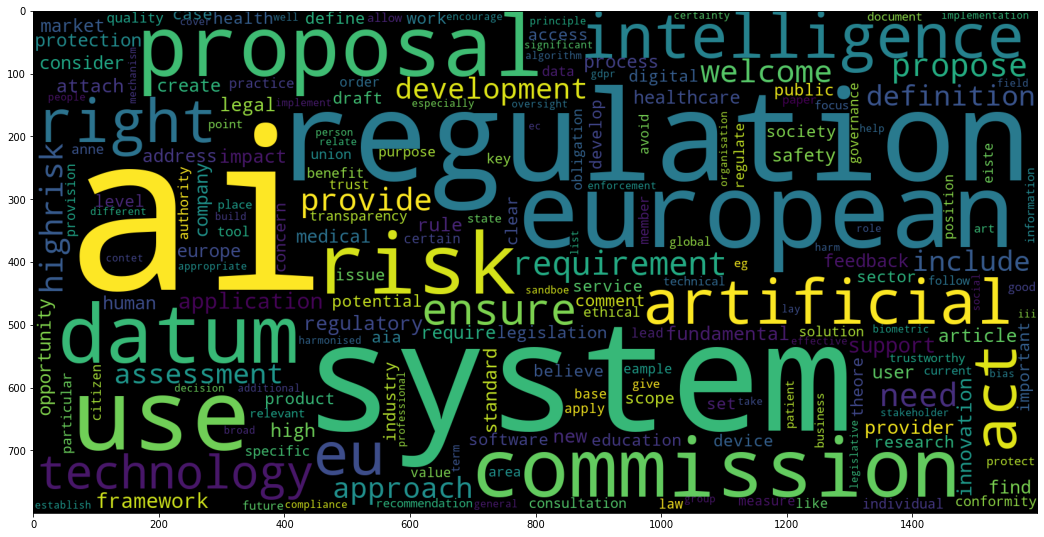

In [81]:
word_counts = lemmatized_word_cloud(docs)

In [82]:
counts = pd.DataFrame(word_counts.most_common(30), columns=['word', 'count'])
plot_counts(counts, ['word', 'count'])

# Named Entities

In [83]:
def get_entities(docs):
  entities = [(ent.text, ent.label_)
         for doc in docs
          for ent in doc.ents]
  return entities

def unique(list1):
  unique_list = []
  for x in list1:
    if x not in unique_list:
      unique_list.append(x)
  return unique_list

def organisation_like_entitites(docs, uniq=False):
  entities = get_entities(docs)
  if uniq:
    entities = unique(entities)
  entities_df = pd.DataFrame(entities, columns =['entity','type'])
  ls = ["EVENT","GPE","LAW","NORP","PERSON","ORG"]
  proper_ets = entities_df[entities_df['type'].isin(ls)]
  return proper_ets

In [84]:
proper_ets = organisation_like_entitites(docs)
proper_ets

,entity,type
0,the institute for social science research ev i...,ORG
1,eu,GPE
5,the european federation,ORG
7,european,NORP
9,european,NORP
...,...,...
1532,european,NORP
1533,european,NORP
1534,european,NORP
1535,pdf,ORG


In [85]:
count_ent = proper_ets.value_counts()
count_ent = count_ent.reset_index()
count_ent.columns =["entity","type","count"]

In [86]:
plot_counts(count_ent[:20],["entity","count"])

# TF-IDF

In [88]:
def dummy_fun(doc):
    return doc

def tfidf_table(texts_df,en,top=10):
  stopwords = en.Defaults.stop_words
  vectorizer = TfidfVectorizer(stop_words=stopwords, use_idf=True, norm=None)
  #vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None) 
  transformed_documents = vectorizer.fit_transform(texts_df)
  #transformed_documents = vectorizer.fit_transform(docs)
  transformed_documents_as_array = transformed_documents.toarray()
  output_filenames = [range(len(transformed_documents_as_array))]
  docs_as_dfs = []
  for counter, doc in enumerate(transformed_documents_as_array):
      tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
      one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
      docs_as_dfs.append(one_doc_as_df)
  top_tfidf = docs_as_dfs[0][:top]
  for i in range(len(docs_as_dfs)-1):
    top_tfidf = pd.concat([top_tfidf, docs_as_dfs[i+1][:10]], axis=1)

  tfidf_names = []
  for i in range(len(docs_as_dfs)):
    tfidf_names.append("term_"+str(i))
    tfidf_names.append("score_"+str(i))
  top_tfidf.columns = tfidf_names
  return top_tfidf

def counts_tfidf(top_tfidf):
  terms_tfidf = top_tfidf.loc[:, ::2]
  terms_list = []
  for i in range(len(terms_tfidf.columns)):
    for j in range(len(terms_tfidf)):
      terms_list.append(terms_tfidf.iloc[j,i])
  terms_freq = Counter(terms_list)
  common_terms = terms_freq.most_common(40)
  count_terms = pd.DataFrame(common_terms, columns=['term', 'count'])
  return count_terms

In [92]:
stopwords = en.Defaults.stop_words
vectorizer = TfidfVectorizer(stop_words=stopwords, use_idf=True, norm=None)
#vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None) 
transformed_documents = vectorizer.fit_transform(df['Text'])
#transformed_documents = vectorizer.fit_transform(docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



In [93]:
transformed_documents_as_array = transformed_documents.toarray()

In [94]:
output_filenames = [range(len(transformed_documents_as_array))]
docs_as_dfs = []
for counter, doc in enumerate(transformed_documents_as_array):
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    docs_as_dfs.append(one_doc_as_df)

In [95]:
top_tfidf = docs_as_dfs[0][:10]
for i in range(len(docs_as_dfs)-1):
  top_tfidf = pd.concat([top_tfidf, docs_as_dfs[i+1][:10]], axis=1)

tfidf_names = []
for i in range(len(docs_as_dfs)):
  tfidf_names.append("term_"+str(i))
  tfidf_names.append("score_"+str(i))
top_tfidf.columns = tfidf_names
top_tfidf

,term_0,score_0,term_1,score_1,term_2,score_2,term_3,score_3,term_4,score_4,...,term_260,score_260,term_261,score_261,term_262,score_262,term_263,score_263,term_264,score_264
0,social,27.939631,efpa,47.122793,health,14.599673,feasible,19.896234,infineon,21.939536,...,smaller,31.183212,workers,54.048657,acceptance,10.969768,toulouse,5.890349,ziegler,5.890349
1,latent,23.561397,psychologists,21.939536,data,14.134037,ai,16.513774,effects,20.492948,...,ai,27.946387,bargaining,27.424420,standards,7.955012,geography,5.890349,institutional,5.890349
2,damage,23.187931,psychology,16.454652,codes,12.055641,requirements,14.904043,ai,19.054355,...,legislators,19.896234,collective,21.931359,single,7.500566,aniti,5.890349,head,5.890349
3,risk,19.058294,organisations,15.001132,dispositions,10.969768,provisions,13.301599,definition,14.738172,...,systems,19.046126,involvement,19.896234,essential,6.575319,chairs,5.890349,kamil,5.890349
4,emotionsensitive,17.671047,regulations,14.349621,conduct,10.763292,generaluse,11.780698,systems,13.851728,...,smes,15.001132,workplace,19.166947,role,6.502584,document,5.644592,affairs,5.484884
5,societal,16.742404,assessments,13.969815,distinction,10.394404,aia,11.626338,ie,12.842734,...,regulation,14.535976,employees,18.550345,ai,6.351452,discusses,5.484884,attach,4.791737
6,harm,15.001132,regularly,13.912758,gdpr,9.753875,regulatory,11.397156,covered,11.626338,...,smallscale,14.375211,rights,17.611757,assigns,5.890349,presents,5.197202,space,4.637586
7,ai,13.973194,fairness,12.556803,stakeholder,9.275172,eisting,10.685893,learning,9.976199,...,highrisk,14.356278,protection,15.910024,paves,5.890349,prepared,5.197202,considering,4.504055
8,relevant,12.598036,current,12.228543,articles,8.772543,systems,10.388796,act,9.021864,...,players,13.158815,ai,15.243484,bolster,5.890349,limitations,4.791737,limits,4.280911
9,eg,12.471042,utilised,11.780698,public,8.075028,deployers,9.583474,technology,9.011052,...,sandboes,13.005167,representatives,14.375211,welcome,5.839869,institute,4.504055,government,4.185601


In [97]:
top_tfidf = tfidf_table(df['Text'],en,top=10)
count_terms = counts_tfidf(top_tfidf)
plot_counts(count_terms, ['term', 'count'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



In [128]:
count_terms[:20]

,term,count
0,ai,114
1,attached,36
2,page,29
3,package,29
4,pace,29
5,systems,28
6,pages,27
7,ownership,25
8,data,24
9,find,24


# Ngrams

## 2-grams

In [99]:
def get_top_ngram(corpus, n=None, m=None):
    vec = CountVectorizer(stop_words = stopwords, ngram_range=(n, m)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]
    
def plot_ngram(top_n_bigrams):
  x,y=map(list,zip(*top_n_bigrams))
  fig= pyplot.subplots(figsize=(15,15))
  sns.barplot(x=y,y=x)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



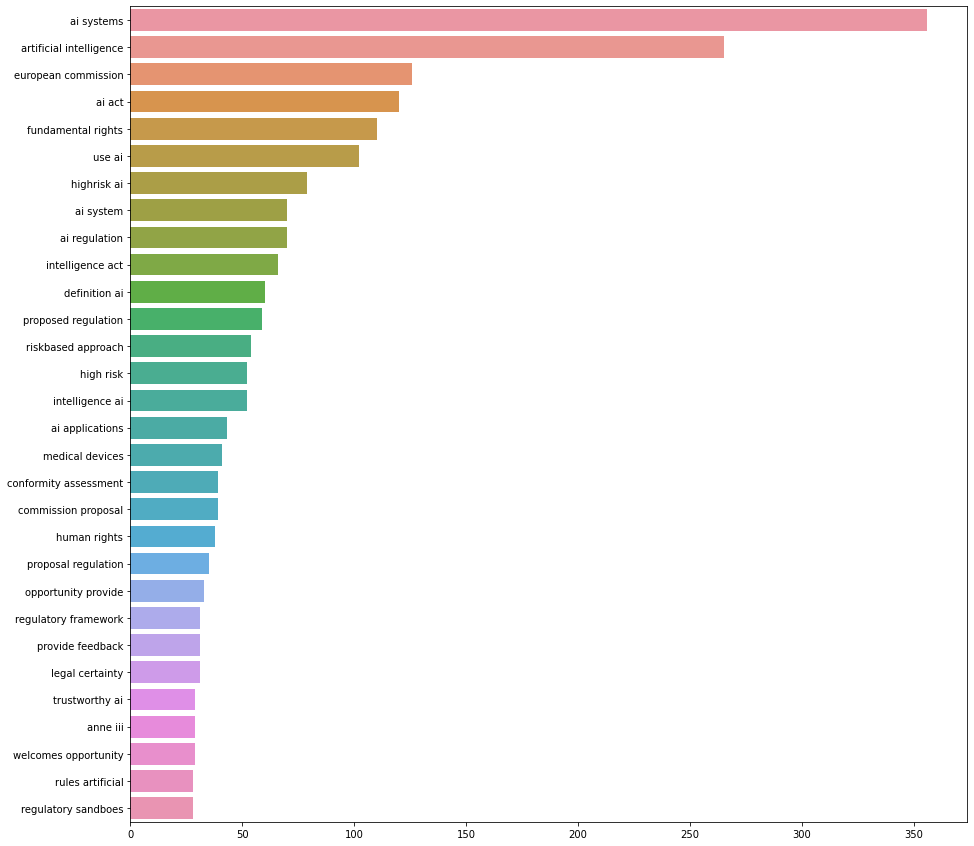

In [101]:
top_n_bigrams=get_top_ngram(df['Text'],2,2)[:30]
plot_ngram(top_n_bigrams)

## 3-grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



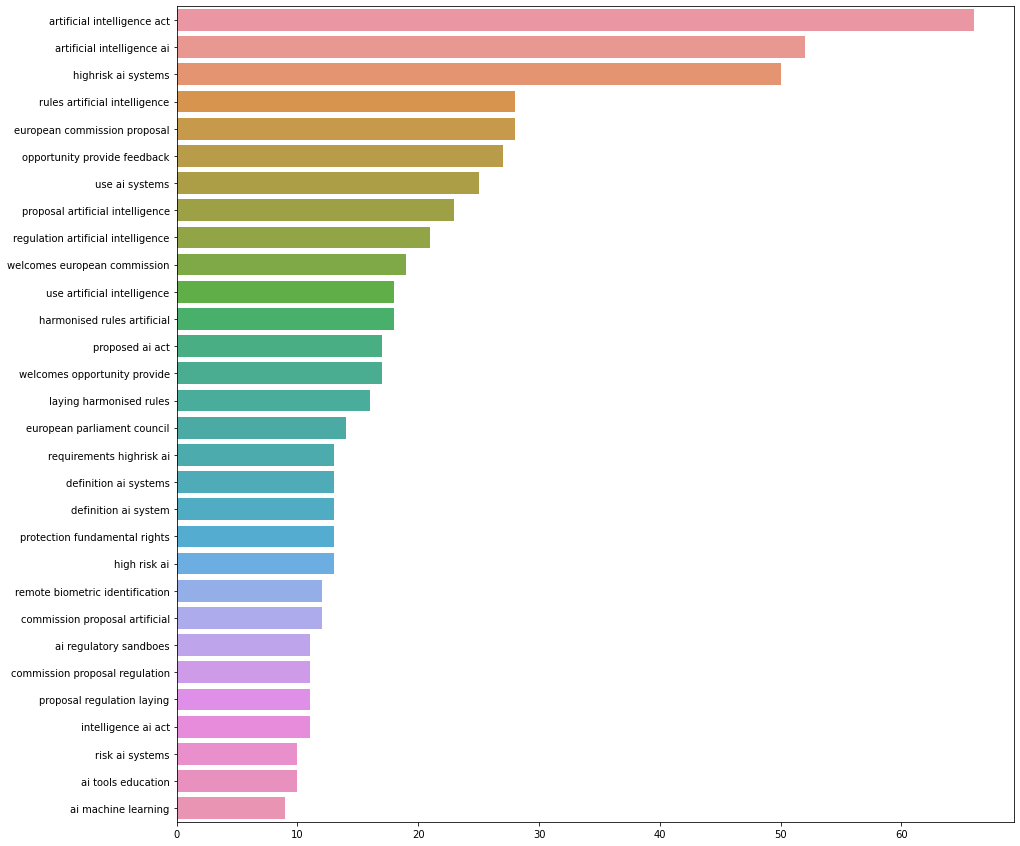

In [102]:
top_n_bigrams=get_top_ngram(df['Text'],3,3)[:30]
plot_ngram(top_n_bigrams)

## 4-grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



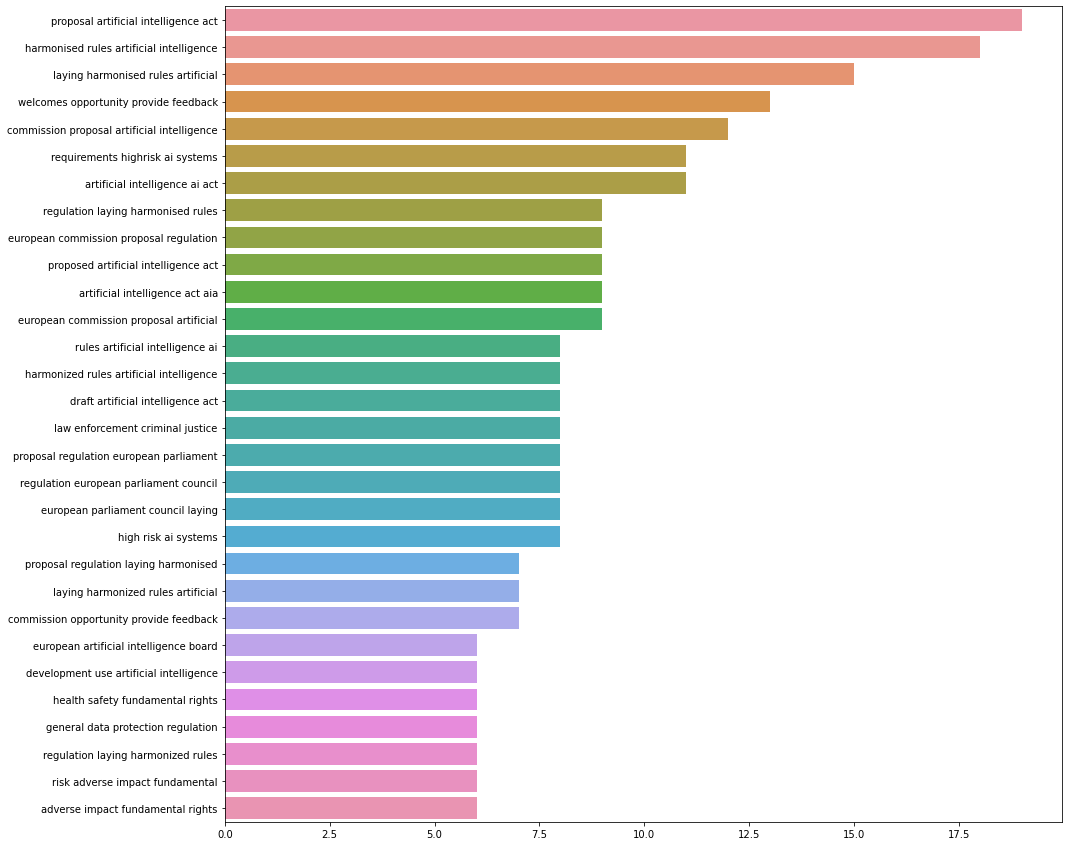

In [103]:
top_n_bigrams=get_top_ngram(df['Text'],4,4)[:30]
plot_ngram(top_n_bigrams)

## 2-5 grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



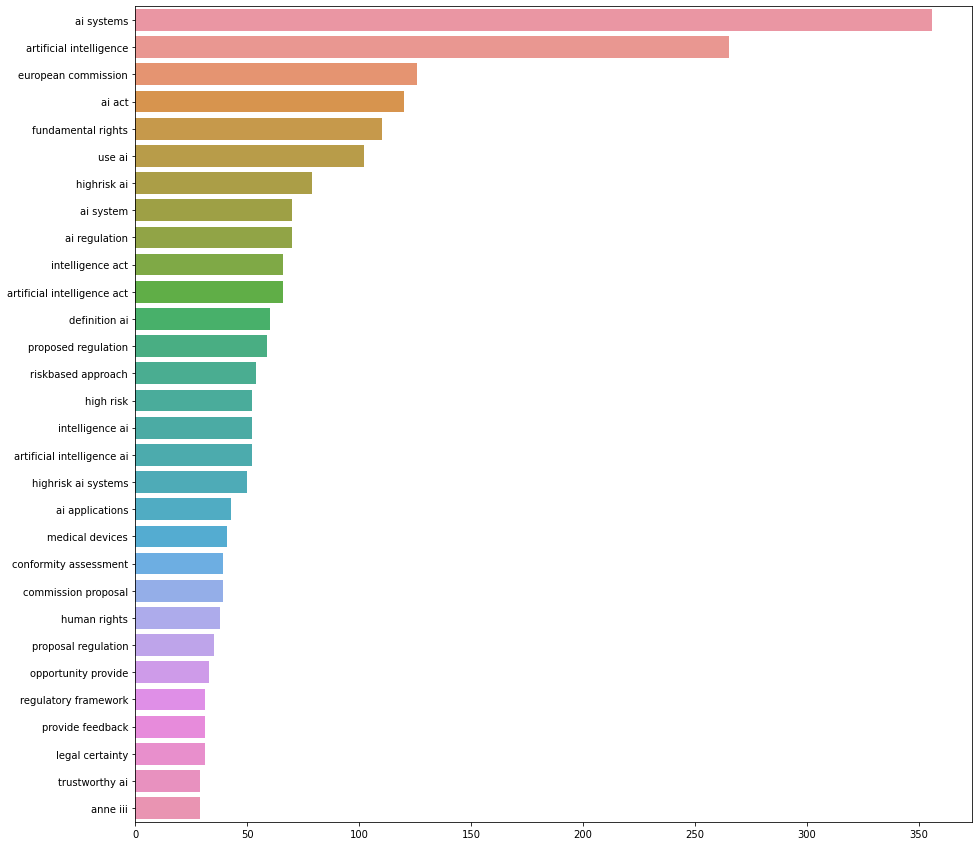

In [104]:
top_n_bigrams=get_top_ngram(df['Text'],2,5)[:30]
plot_ngram(top_n_bigrams)

# Noun Chunks

Proposition for n-gram like structure from spacy creators. It focuses on ngrams focused on nouns.

In [106]:
def get_noun_chunks(docs):
  noun_chunks = []
  for doc in docs:
    for chunk in doc.noun_chunks:
      noun_chunks.append(chunk.text)
  return noun_chunks

In [107]:
noun_chunks = get_noun_chunks(docs)

## At least two words

In [108]:
lim_noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(lim_noun_chunks,['chunk', 'count'])
plot_counts(count_chunks,['chunk', 'count'])

## At least three words

In [109]:
noun_chunks = list(filter(lambda x: len(x.split()) > 2, noun_chunks))

chunk_freq = Counter(noun_chunks)
common_chunks = chunk_freq.most_common(20)

count_chunks = pd.DataFrame(common_chunks, columns=['chunk', 'count'])

fig = px.bar(count_chunks,orientation='h', y='chunk', x='count')

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(bargap=0.30, font={'size':10})
fig

## More complex analysis

In [129]:
noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(noun_chunks,['chunk', 'count'],40)
plot_counts(count_chunks,['chunk', 'count'])

In [116]:
def get_chunks(docs):
  chunks = list()
  for doc in docs:
    chunks = chunks + list(doc.noun_chunks)
  return chunks

def top_chunk_parents(chunks,count_chunks,n_chunks=10,n_parents=5):
  chunk_parents = []
  for chunk in chunks:
    if chunk.text in (list(count_chunks["chunk"][:n_chunks])):
      chunk_parents.append((chunk.text,chunk.root.head.text))
  ch_p_df = pd.DataFrame(chunk_parents, columns =['chunk','parent'])
  count_ch_p = ch_p_df.value_counts()
  count_ch_p = count_ch_p.reset_index()
  count_ch_p.columns =["chunk","parent","count"]
  most_common_parents = []
  for el in list(count_chunks["chunk"][:n_chunks]):
    p = count_ch_p[count_ch_p["chunk"]== el][:n_parents]
    most_common_parents.append(p)
  return most_common_parents

def count_texts(texts,colnames=['obj', 'count'],n_obs=30):
  obj_freq = Counter(texts)
  common_obj = obj_freq.most_common(n_obs)
  count_obj = pd.DataFrame(common_obj, columns=colnames)
  return count_obj

In [111]:
chunks = get_chunks(docs)

In [112]:
most_common_parents = top_chunk_parents(chunks,count_chunks)

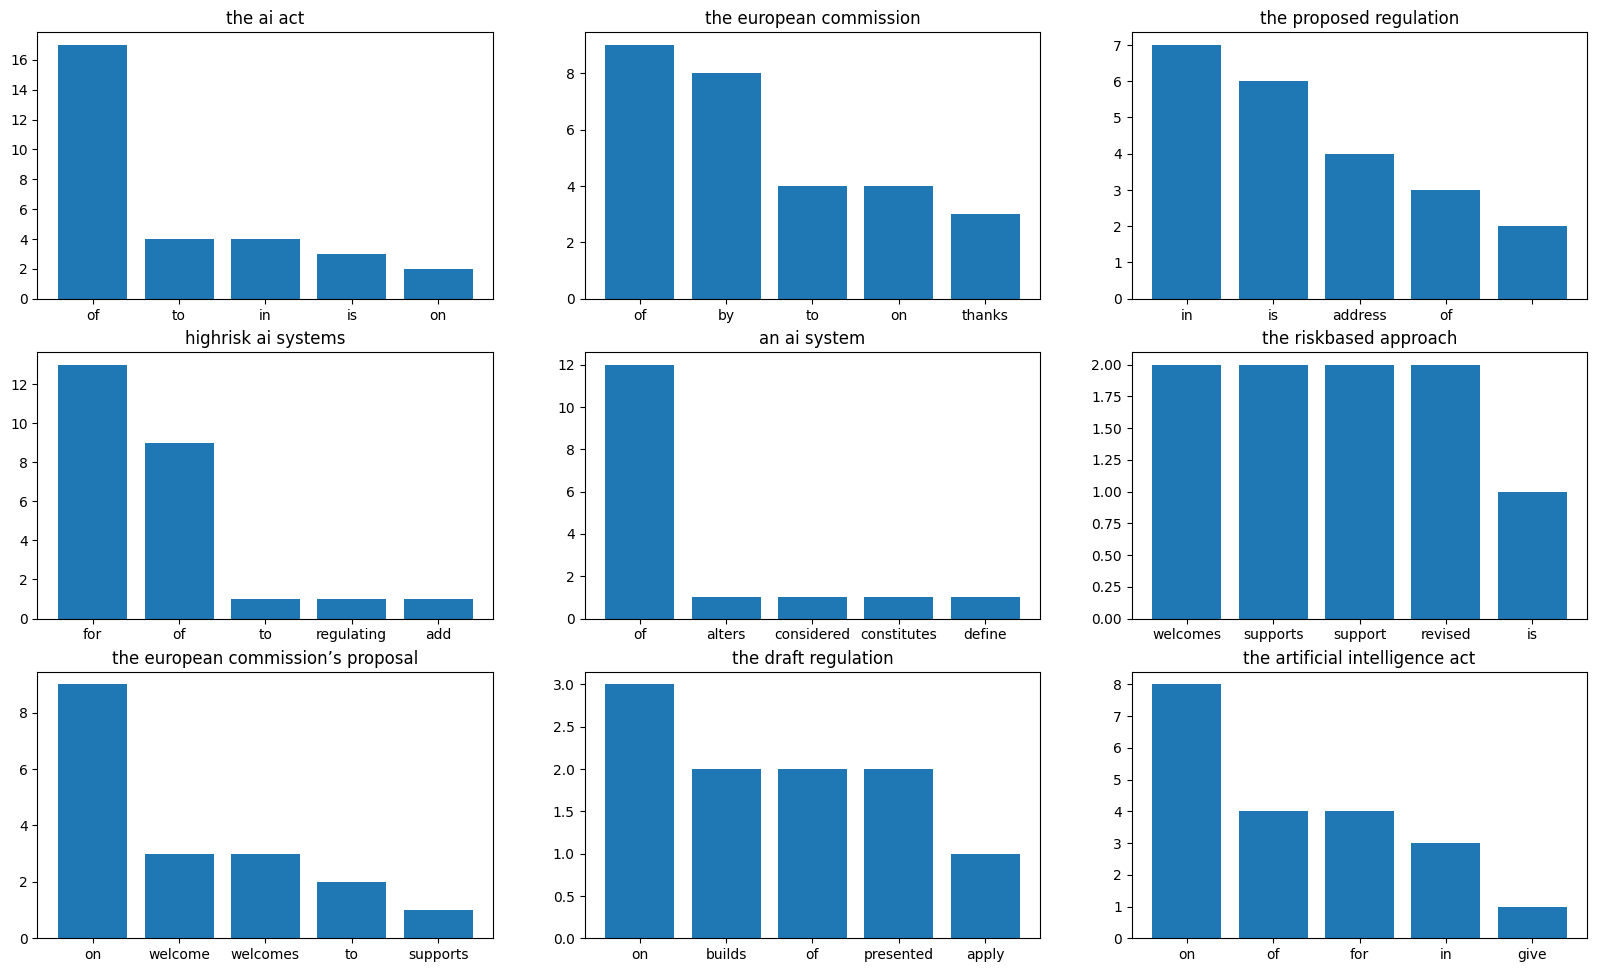

In [115]:
figure(figsize=(20, 12), dpi=100)
plt.figure(1)
for i in range(9):
  plt.subplot(331+i)
  plt.bar(most_common_parents[i]["parent"], most_common_parents[i]["count"])
  plt.title(most_common_parents[i]["chunk"].iloc[0])

## Chunk Frequency

In [117]:
freq_chunk = []
for doc in docs:
  n_chunks = []
  for chunk in doc.noun_chunks:
    n_chunks.append(chunk.text)
  freq_chunk.append(n_chunks)

In [118]:
noun_chunks = get_noun_chunks(docs)
noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(noun_chunks,['chunk', 'count'],10)
common_chunks = count_chunks['chunk']
count_chunks = count_chunks['count']
common_chunks[0]


'ai systems'

In [119]:
count_chunk = []
for ch in common_chunks:
  print(ch)
  x=0
  for i in range(len(freq_chunk)):
    if ch in freq_chunk[i]:
      x+=1
  count_chunk.append(x)
count_chunk[:3]

ai systems
the proposal
artificial intelligence
the regulation
the use
the commission
fundamental rights
the eu
the opportunity
the ai act


[88, 82, 92]

In [120]:
ch_name = []
ch_count = []
for ch in common_chunks:
  ch_name.append(ch)
for ch in count_chunks:
  ch_count.append(ch)
ch_name[:5]
ch_count[:5]

[195, 160, 127, 118, 92]

In [130]:
chunk_count_df = pd.DataFrame(ch_name)
chunk_count_df["Count"] = ch_count
chunk_count_df["CF"] = count_chunk
chunk_count_df["Percent"] = [x / len(docs) for x in count_chunk]
chunk_count_df.columns = ["Chunk","Count","ChunkFrequency", "Percent"]
chunk_count_df[:10]

,Chunk,Count,ChunkFrequency,Percent
0,ai systems,195,88,0.332075
1,the proposal,160,82,0.309434
2,artificial intelligence,127,92,0.347170
3,the regulation,118,57,0.215094
4,the use,92,56,0.211321
5,the commission,76,45,0.169811
6,fundamental rights,70,44,0.166038
7,the eu,67,47,0.177358
8,the opportunity,65,63,0.237736
9,the ai act,61,30,0.113208


In [122]:
list(chunk_count_df["Chunk"])[:5]

['ai systems',
 'the proposal',
 'artificial intelligence',
 'the regulation',
 'the use']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



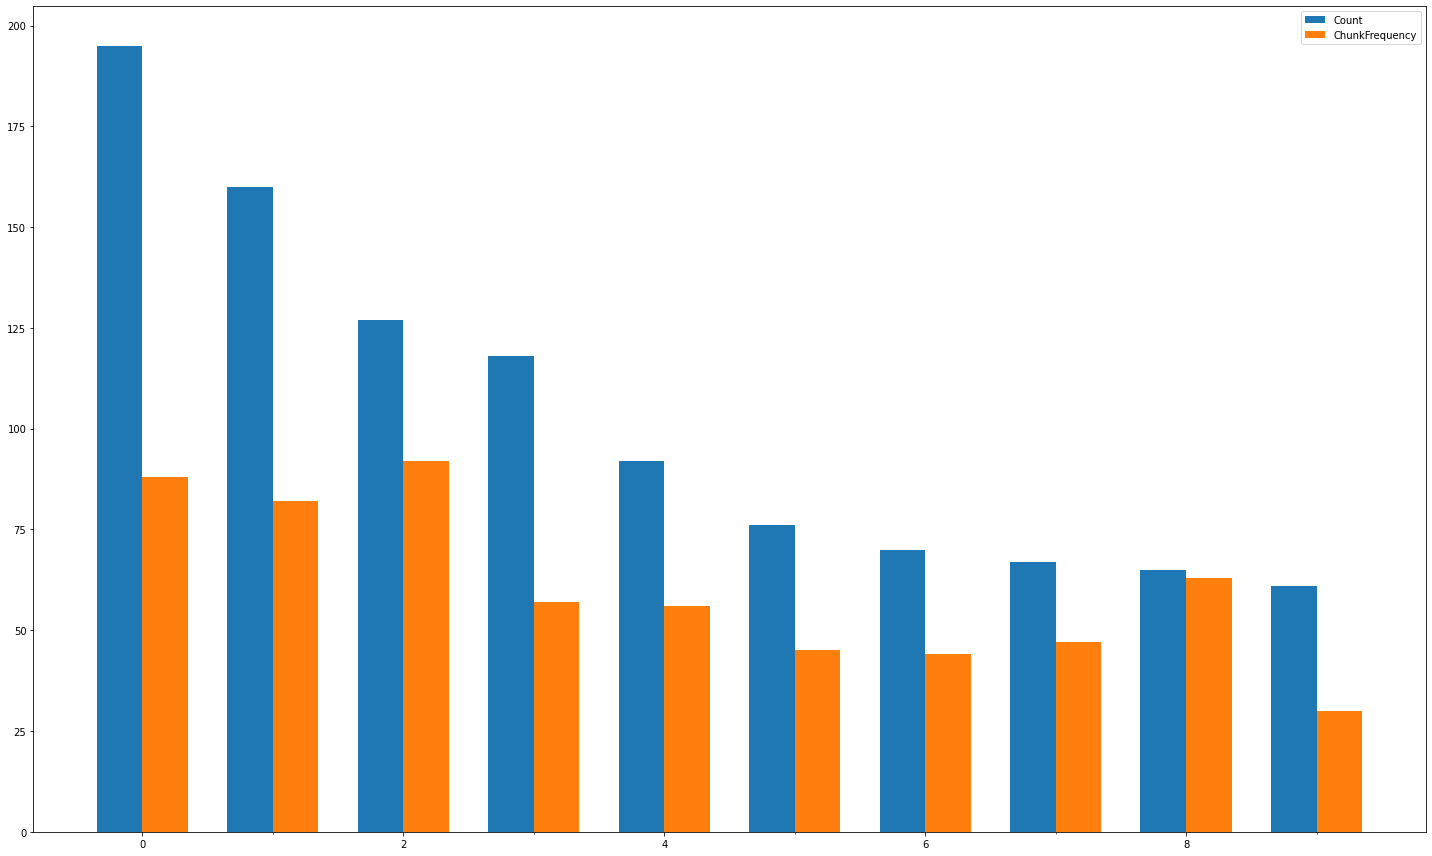

In [126]:
labels = list(chunk_count_df["Chunk"])

x = np.arange(len(chunk_count_df["Chunk"]))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 12))
rects1 = ax.bar(x - width/2, chunk_count_df["Count"], width, label='Count')
rects2 = ax.bar(x + width/2, chunk_count_df["ChunkFrequency"], width, label='ChunkFrequency')

ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()